# __Neural Network__ (vgg16; fasion_mnist)

Створити `згорткову нейромережу`, що використовує `VGG16` в якості згорткової основи.

In [106]:
import math
import os
import random
from typing import Optional, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from keras.optimizers import Optimizer
from sklearn.model_selection import train_test_split


In [107]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

In [108]:
(images_train, labels_train), (images_test, labels_test) = fashion_mnist.load_data()
images_train.dtype, images_train[0].shape

(dtype('uint8'), (28, 28))

In [109]:
# hyperparameters+
cfg = {
       #'learning_rate': 0.001,
       'steps_per_epoch': 100,
       'batch_size': 512, # для перерахунку ваг не на всій вибірці
       # 'display_step': 100,
       #'n_hidden_1': 256,
       #'n_hidden_2': 64,
       'validation_steps': 100,
       'epochs_limit': 100,
       }

In [110]:
cfg['num_features'] = images_train[0].shape[0] * images_train[0].shape[1]
cfg.get('num_features')

784

In [111]:
images_train, images_test = np.array(images_train, np.float32), np.array(images_test, np.float32)  # .astype('float32')

print(min(images_train.min(), images_test.min()))
maximum = max(images_train.max(), images_test.max()) # np.max([images_train.max(), images_test.max()]) 
maximum

0.0


255.0

In [112]:
# Normalize (min = 0):
images_train, images_test = images_train / maximum, images_test / maximum

In [113]:
images_train.shape, images_test.shape, labels_train.shape, labels_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [114]:
max(labels_train.max(), labels_test.max()), min(labels_train.min(), labels_test.min())

(9, 0)

In [115]:
cfg['num_classes'] = len(set(np.concatenate((labels_train, labels_test), axis=0)))
cfg.get('num_classes')

10

In [116]:
images_valid, images_test, labels_valid, labels_test = train_test_split(
                                                                        images_test, 
                                                                        labels_test, 
                                                                        test_size=0.5,  # 50% for test
                                                                        shuffle=True, 
                                                                        stratify=labels_test
                                                                        )  # (stratify для рівномірного розподілу за значенням y = labels_test)

In [117]:
images_valid.shape, images_test.shape, labels_valid.shape, labels_test.shape

((5000, 28, 28), (5000, 28, 28), (5000,), (5000,))

In [118]:
labels_train = tf.one_hot(labels_train, depth=cfg.get('num_classes')).numpy()
labels_test = tf.one_hot(labels_test, depth=cfg.get('num_classes')).numpy()
labels_valid = tf.one_hot(labels_valid, depth=cfg.get('num_classes')).numpy()
# labels_train = to_categorical(labels_train, num_classes = cfg.get('num_classes'))
# labels_test = to_categorical(labels_test, num_classes = cfg.get('num_classes'))
# labels_valid = to_categorical(labels_valid, num_classes = cfg.get('num_classes'))
labels_train.shape, labels_test.shape, labels_valid.shape  # ((60000, 10), (10000, 10)) to ((60000, 10), (5000, 10), (5000, 10))

((60000, 10), (5000, 10), (5000, 10))

In [119]:
images_train.shape, images_test.shape, images_valid.shape, labels_train.shape, labels_test.shape, labels_valid.shape

((60000, 28, 28),
 (5000, 28, 28),
 (5000, 28, 28),
 (60000, 10),
 (5000, 10),
 (5000, 10))

- https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
- https://stackoverflow.com/questions/64276472/valueerror-the-input-must-have-3-channels-got-input-shape-200-200-1

In [120]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, shuffle=True, batch_size=256, to_size=32):
        self.X = X  # (60000, 28, 28)
        self.y = y  # (60000, 10)
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.batch_size = batch_size
        self.to_size = to_size
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)
    
    def __getitem__(self, idx):  # idx = batche's numder
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_X_row = [self.X[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]

        # cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)
        batch_X = [cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB) for img in batch_X_row]

        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [121]:
cfg.get('batch_size')

512

In [122]:
train_datagen = Dataset(X=images_train, y=labels_train, batch_size=cfg.get('batch_size'))  # to_size=48
train_datagen[0][0].shape

(512, 32, 32, 3)

In [127]:
valid_datagen = Dataset(X=images_valid, y=labels_valid, batch_size=1) 
valid_datagen[0][0].shape

(1, 32, 32, 3)

In [128]:
test_datagen = Dataset(X=images_test, y=labels_test, batch_size=1)
test_datagen[0][0].shape

(1, 32, 32, 3)

### __`MODEL`__

In [129]:
cfg['filter'] = 256  # output_depth
# activation_functions = ['relu' for _ in range(4)] + ['softmax']

- https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://stackoverflow.com/questions/64276472/valueerror-the-input-must-have-3-channels-got-input-shape-200-200-1
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

In [130]:
conv_base = VGG16(
                  include_top=False,  # False = own data-classifier, not built-in
                  weights='imagenet',  # source of weights for model initialization
                  # input_tensor=None,  # optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. 
                  input_shape=(train_datagen[0][0].shape[1], train_datagen[0][0].shape[2], 3),  # optional shape tuple
                  # pooling=None,  # Optional pooling
                  # classes=10,
                  # classifier_activation='softmax'
                  )

conv_base.trainable = False

model = Sequential([
                    conv_base,
                    layers.Flatten(),
                    layers.Dense(cfg.get('filter'), activation='relu'),
                    layers.Dense(cfg.get('num_classes'), activation='softmax'),
                    ])

model.compile(
              loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy']
              )

In [131]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#### __`Training`__

In [86]:
history = model.fit(
                    train_datagen,
                    steps_per_epoch=cfg.get('steps_per_epoch'),
                    epochs=cfg.get('epochs_limit'),
                    validation_data=valid_datagen,
                    validation_steps=cfg.get('validation_steps')
                    )

Epoch 1/100
100/100 [==============================] - 121s 1s/step - loss: 1.6913 - accuracy: 0.5464 - val_loss: 1.3237 - val_accuracy: 0.6700
Epoch 2/100
100/100 [==============================] - 120s 1s/step - loss: 1.0075 - accuracy: 0.7294 - val_loss: 0.8902 - val_accuracy: 0.7400
Epoch 3/100
100/100 [==============================] - 120s 1s/step - loss: 0.7671 - accuracy: 0.7619 - val_loss: 0.7100 - val_accuracy: 0.7100
Epoch 4/100
100/100 [==============================] - 122s 1s/step - loss: 0.6685 - accuracy: 0.7815 - val_loss: 0.8179 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 120s 1s/step - loss: 0.6128 - accuracy: 0.7942 - val_loss: 0.7447 - val_accuracy: 0.7200
Epoch 6/100
100/100 [==============================] - 121s 1s/step - loss: 0.5776 - accuracy: 0.8041 - val_loss: 0.6569 - val_accuracy: 0.7800
Epoch 7/100
100/100 [==============================] - 120s 1s/step - loss: 0.5524 - accuracy: 0.8086 - val_loss: 0.5425 - val_accuracy:

In [80]:
# history = model.fit(images_train, labels_train, epochs=cfg.get('epochs_limit'), batch_size=cfg.get('batch_size'))  # w/o valid data

### __`INTERPRET`__ / __`Error Analysis`__

In [87]:
history.history

{'loss': [1.6913185119628906,
  1.0074689388275146,
  0.7670820951461792,
  0.6684633493423462,
  0.6127824187278748,
  0.5776265859603882,
  0.5523810386657715,
  0.5314154624938965,
  0.517551064491272,
  0.5034890174865723,
  0.4919044077396393,
  0.4840230643749237,
  0.4725455641746521,
  0.4679070711135864,
  0.46288561820983887,
  0.45742714405059814,
  0.45031630992889404,
  0.4460015892982483,
  0.44113725423812866,
  0.4374391436576843,
  0.4366421103477478,
  0.4299819767475128,
  0.42737892270088196,
  0.42262163758277893,
  0.4214867055416107,
  0.4162239730358124,
  0.41417640447616577,
  0.41124895215034485,
  0.40959632396698,
  0.40894022583961487,
  0.40516430139541626,
  0.4036356806755066,
  0.4001120328903198,
  0.3989056944847107,
  0.3975076973438263,
  0.3940325975418091,
  0.3935992121696472,
  0.39269760251045227,
  0.3922567069530487,
  0.3879665434360504,
  0.38679200410842896,
  0.3849364221096039,
  0.38259395956993103,
  0.3820127248764038,
  0.3792800009

In [88]:
# history.history

In [89]:
# valid_loss, valid_acc = model.evaluate(images_valid, labels_valid)
# print(valid_acc)
# test_loss, test_acc = model.evaluate(images_test, labels_test)
# print(test_acc)

In [90]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

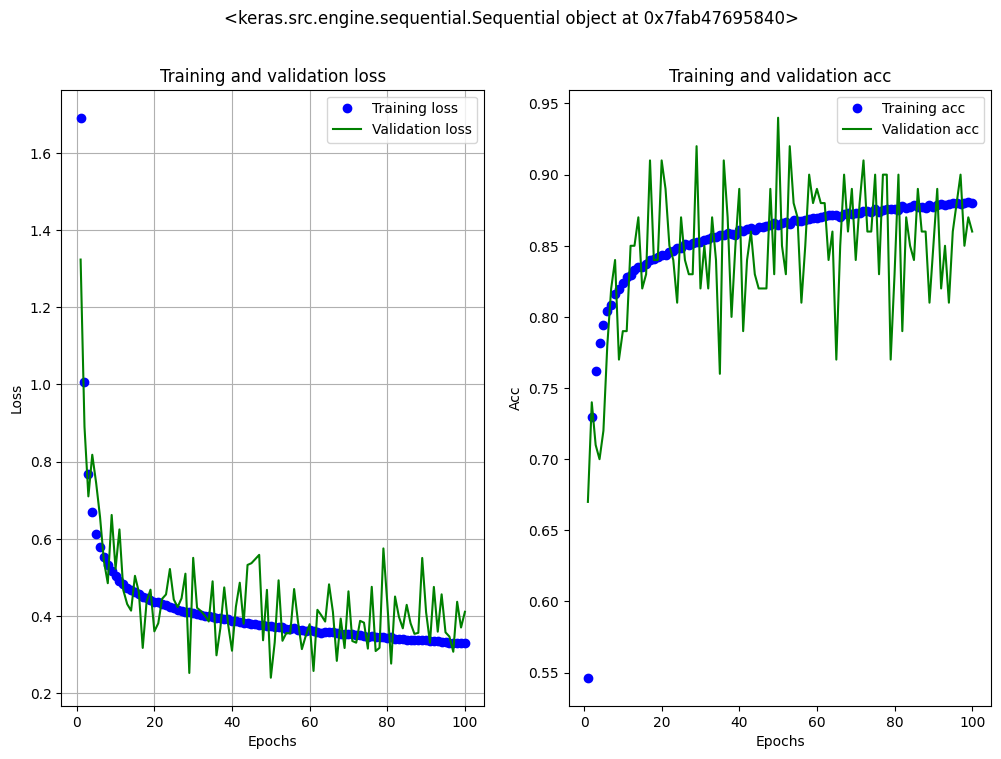

In [92]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']   

draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

# .-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-......

In [ ]:
# model = Sequential([
#                     conv_base,
#                     layers.Flatten(),
#                     layers.Dense(cfg.get('filter'), activation='relu'),
#                     layers.Dense(cfg.get('num_classes'), activation='softmax'),
#                     ])

# model.compile(
#               loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
#               metrics=['accuracy']
#               )

In [132]:
cfg

{'steps_per_epoch': 100,
 'batch_size': 512,
 'validation_steps': 100,
 'epochs_limit': 100,
 'num_features': 784,
 'num_classes': 10,
 'filter': 256}

In [140]:
cfg['epochs_limit'] = 2
cfg['filter'] = 32

In [134]:
class ModelConv2D:
    def __init__(self, filters: list, activations: list) -> None:
        self.model = Sequential([
                                 conv_base,
                                 layers.Flatten(),
                                 layers.Dense(filters[0], activation=activations[0]),
                                 layers.Dense(filters[1], activation=activations[1]),
                                 ])

        
    def compile(self, opt: Union[str, Optimizer], loss: Union[str, losses.CategoricalCrossentropy()], metrics: list) -> None:
        self.model.compile(
                           optimizer=opt,
                           loss=loss,
                           metrics=metrics
                           )

    def summary(self) -> None:
        self.model.summary()
    

In [135]:
model = ModelConv2D(
                    filters=[cfg.get('filter'), cfg.get('num_classes')],
                    activations=['relu', 'softmax'],
                    )
# model.compile(opt='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam   # metrics.BinaryAccuracy()  CategoricalAccuracy()
model.compile(opt=optimizers.legacy.RMSprop(learning_rate=0.01), loss=losses.CategoricalCrossentropy(), metrics=metrics.CategoricalAccuracy())

In [136]:
type(model), type(model.model)

(__main__.ModelConv2D, keras.src.engine.sequential.Sequential)

In [137]:
model.model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 dense_11 (Dense)            (None, 10)                330       
                                                                 
Total params: 14731434 (56.20 MB)
Trainable params: 16746 (65.41 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [138]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 dense_11 (Dense)            (None, 10)                330       
                                                                 
Total params: 14731434 (56.20 MB)
Trainable params: 16746 (65.41 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# history = model.fit(
#                     train_datagen,
#                     steps_per_epoch=cfg.get('steps_per_epoch'),
#                     epochs=cfg.get('epochs_limit'),
#                     validation_data=valid_datagen,
#                     validation_steps=cfg.get('validation_steps')
#                     )

In [142]:
class TrainerModelConv2D:
    def __init__(self, model: ModelConv2D) -> None:
        self.model = model.model

    def train(self, train_datagen: Dataset, steps_per_epoch: int, epochs: int, validation_steps: int, validation_data: Optional[Dataset]=None) -> None:
        self.history = self.model.fit(
                                      train_datagen,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      validation_steps=validation_steps,
                                      validation_data=validation_data
                                      )
        
    def draw_results(self, caption: str) -> None:  # ! categorical_accuracy or accuracy ? exclude function
        history_dict = self.history.history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=caption)

    def trained_model(self) -> models.Sequential():
        return self.model

Epoch 1/2
100/100 [==============================] - 122s 1s/step - loss: 0.9058 - categorical_accuracy: 0.6880 - val_loss: 0.5627 - val_categorical_accuracy: 0.7800
Epoch 2/2
100/100 [==============================] - 120s 1s/step - loss: 0.5348 - categorical_accuracy: 0.8063 - val_loss: 0.6258 - val_categorical_accuracy: 0.7700


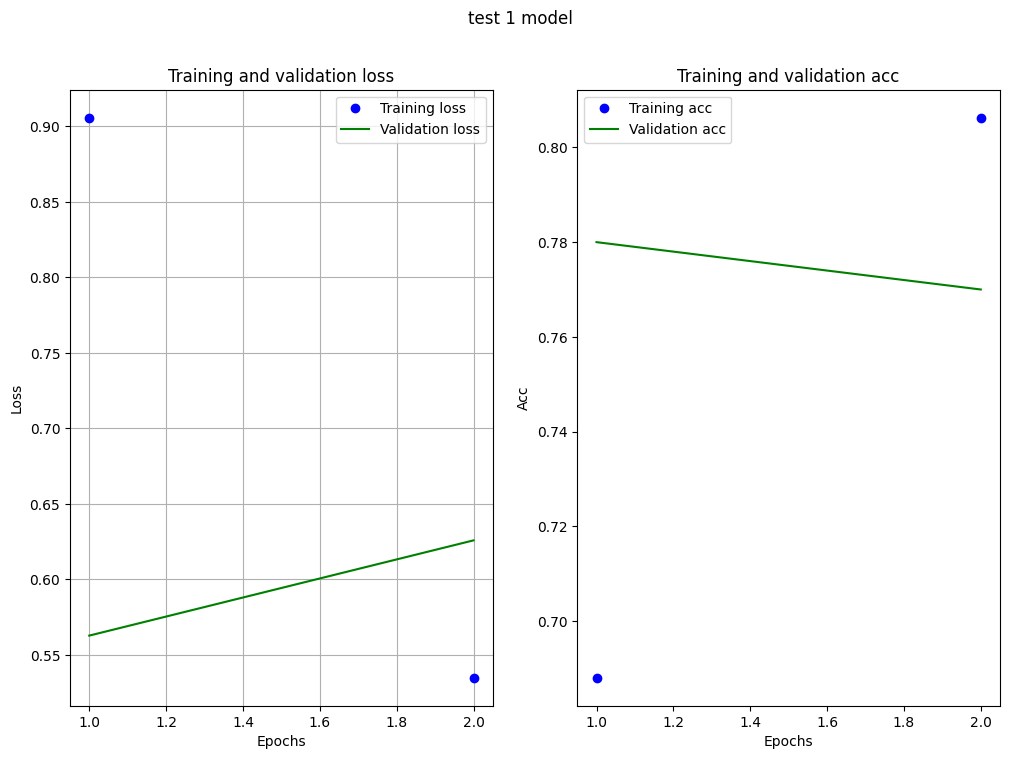

In [143]:
train_1 = TrainerModelConv2D(model)
train_1.train(
              train_datagen=train_datagen, 
              steps_per_epoch=cfg.get('steps_per_epoch'), 
              epochs=cfg.get('epochs_limit'), 
              validation_steps=cfg.get('validation_steps'), 
              validation_data=valid_datagen
              )
train_1.draw_results('test 1 model')

In [144]:
train_1.trained_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 dense_11 (Dense)            (None, 10)                330       
                                                                 
Total params: 14731434 (56.20 MB)
Trainable params: 16746 (65.41 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [145]:
test_loss, test_acc = train_1.trained_model().evaluate(test_datagen)
print(round(test_acc, 4))

   4/5000 [..............................] - ETA: 1:32 - loss: 0.7191 - categorical_accuracy: 0.7500    

5000/5000 [==============================] - 72s 14ms/step - loss: 0.4765 - categorical_accuracy: 0.8256
0.8256


### test randoms impact

- 1 train, valid, test (no testing)
- 2 test model in various random state

In [161]:
cfg = {
       'steps_per_epoch': 100,
       'batch_size': 256,
       'validation_steps': 100,
       'epochs_limit': 5,
       'num_features': 784,
       'num_classes': 100,
       'filter': 32,
       }

set_seed(1)

In [159]:
my_models = {}
for num in range(10):
    set_seed(num*10)
    model = ModelConv2D(
                        filters=[cfg.get('filter'), cfg.get('num_classes')],
                        activations=['relu', 'softmax'],
                        )
    # model.compile(opt='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam   # metrics.BinaryAccuracy()  CategoricalAccuracy()
    model.compile(opt=optimizers.legacy.Adam(learning_rate=0.005), loss=losses.CategoricalCrossentropy(), metrics=metrics.CategoricalAccuracy())
    my_models[f'''{num}-{model.model.name}-{optimizers.legacy.Adam()._name}-lr0.005-bs{cfg.get('batch_size')}'''] = model

my_models

{'0-sequential_40-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3ad71f90>,
 '1-sequential_41-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3ac01750>,
 '2-sequential_42-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3ac027a0>,
 '3-sequential_43-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3ac03850>,
 '4-sequential_44-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3908a7a0>,
 '5-sequential_45-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3908b670>,
 '6-sequential_46-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3908ba60>,
 '7-sequential_47-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab390d3670>,
 '8-sequential_48-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3911bfa0>,
 '9-sequential_49-Adam-lr0.005-bs256': <__main__.ModelConv2D at 0x7fab3911ae30>}

### Training mosel set

Epoch 1/5
100/100 [==============================] - 114s 1s/step - loss: 0.5442 - categorical_accuracy: 0.8071 - val_loss: 0.4818 - val_categorical_accuracy: 0.8500
Epoch 2/5
100/100 [==============================] - 114s 1s/step - loss: 0.4539 - categorical_accuracy: 0.8360 - val_loss: 0.3682 - val_categorical_accuracy: 0.8900
Epoch 3/5
100/100 [==============================] - 113s 1s/step - loss: 0.4268 - categorical_accuracy: 0.8459 - val_loss: 0.3412 - val_categorical_accuracy: 0.8800
Epoch 4/5
100/100 [==============================] - 114s 1s/step - loss: 0.4065 - categorical_accuracy: 0.8522 - val_loss: 0.4184 - val_categorical_accuracy: 0.8600
Epoch 5/5
100/100 [==============================] - 114s 1s/step - loss: 0.3931 - categorical_accuracy: 0.8579 - val_loss: 0.5267 - val_categorical_accuracy: 0.8300
Epoch 1/5
100/100 [==============================] - 113s 1s/step - loss: 0.5557 - categorical_accuracy: 0.8046 - val_loss: 0.4150 - val_categorical_accuracy: 0.8900
Epoc

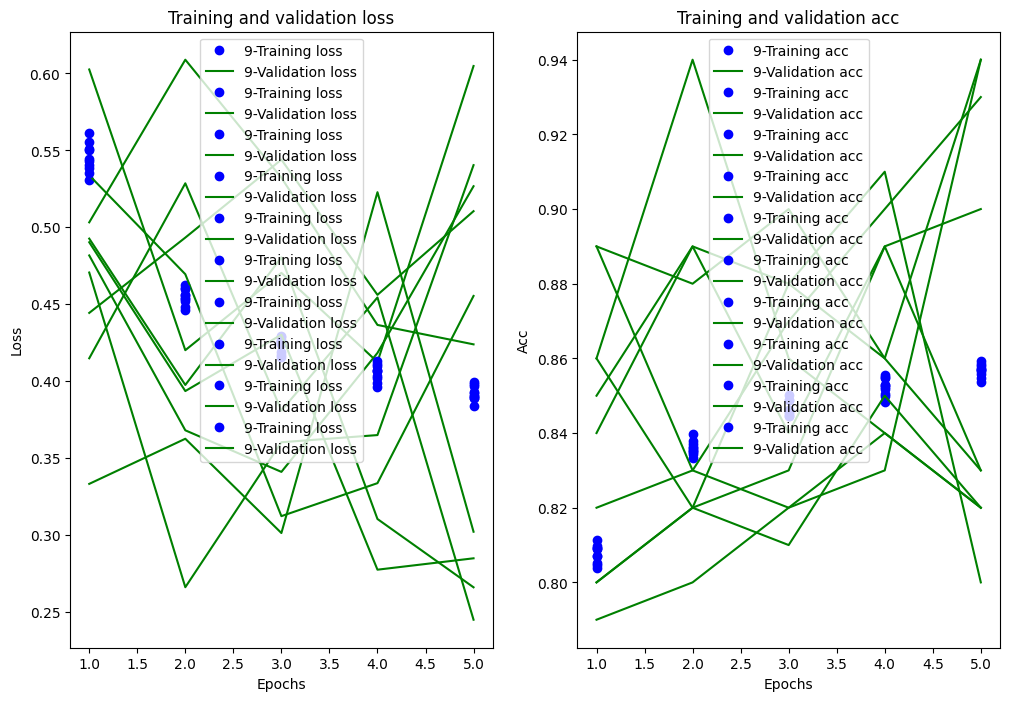

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

for model_name, model in my_models.items():
    train_1 = TrainerModelConv2D(model)
    train_1.train(
              train_datagen=train_datagen, 
              steps_per_epoch=cfg.get('steps_per_epoch'), 
              epochs=cfg.get('epochs_limit'), 
              validation_steps=cfg.get('validation_steps'), 
              validation_data=valid_datagen
              )
    
    history_dict = train_1.history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['categorical_accuracy']
    val_acc_values = history_dict['val_categorical_accuracy']

    x = range(1, len(loss_values) + 1)

    axs[0].plot(x, loss_values, 'bo', label=f'{num}-Training loss')
    axs[0].plot(x, val_loss_values, 'g', label=f'{num}-Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, acc_values, 'bo', label=f'{num}-Training acc')
    axs[1].plot(x, val_acc_values, 'g', label=f'{num}-Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    # fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()

plt.show()
    

random impact to training: <br>
train accuracy delta = +-0.005 (0.5%)<br>
validation accuracy delta = +-0.075 (7.5%)